In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.ascii
%matplotlib inline

In [18]:
pip install radvel

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pylightcurve

Note: you may need to restart the kernel to use updated packages.


## Read in RV data for HD 17156 b

In [4]:
rv_data = astropy.io.ascii.read("UID_0057087_RVC_003.tbl.txt")

rv_data.columns

<TableColumns names=('JD','Radial_Velocity','Radial_Velocity_Uncertainty')>

In [5]:
import pylightcurve as plc

planet = plc.get_planet('gj436b')

    Done!
Checking exotethys database...
Checking ephemerides database...
Checking photometry database...
Checking catalogues database...


## Plot the best-fit model

The five parameters in orbital solution are
1. Period (T)
2. Time at periastron ($t_0$)
3. Eccentricity (e)
4. Longitude of periastron ($\omega$)
5. RV semi-amplitude (K) 

We have obtained these values [here](https://exoplanetarchive.ipac.caltech.edu/overview/gj436b). 

/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/radvel/gp.py:33: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  Try installing celerite using 'pip install celerite'", ImportWarning)


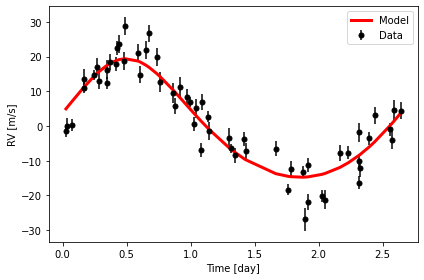

In [6]:
t = rv_data["JD"].data
if False:
    import JW_lib
    orbital_solution = [2.64388312, 2455959, 0.13827, 351.00, 17.09]
    rv = JW_lib.RadialVelocity(orbital_solution)
    # The parameters are period, time at periastron, eccentricity, argument of periastron, RV semi-amplitude

    # Calculate model RVs
    rvs = rv.rv_drive(t)
else:
    import radvel
    orbital_solution = [2.64388312, 2455959,  0.13827, 351.00 / 360.0 * 2 * np.pi, 17.09]
    rvs = radvel.kepler.rv_drive(t, orbital_solution, use_c_kepler_solver=False)

per = 2.64388312

%matplotlib inline
# Fold data and plot model against data
ind = np.argsort(t % per)
plt.errorbar(rv_data["JD"] % per, rv_data["Radial_Velocity"], rv_data["Radial_Velocity_Uncertainty"], 
             color="black", ms=5, marker="o", ls="none", label="Data")
plt.plot((t % per)[ind], rvs[ind], "r-", label="Model", lw=3)
plt.legend()
plt.xlabel("Time [day]")
plt.ylabel("RV [m/s]")
plt.tight_layout()

### Calculating the Planet's Mass

The radial velocity semi-major amplitude is given by the following equation 
$K = \frac{M_{p}}{M_{*}} \sqrt{\frac{G M_{*}}{a}} \cdot \sin(i)$

We can rearrange this equation to solve for the mass of the planet:

$M_{p} = \frac{K M_{*}}{\sin(i)} \sqrt{\frac{a}{G M_{*}}}$

We find K, mass of the star $M_{*}$, inclination i, semi-major axis a, and gravitational constant G on [Nasa's Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/overview/GJ%20436%20b#planet_GJ-436-b_collapsible).  

In [38]:
# Pulling data from NASA
# Mass of star
M_star = 0.4411671425335000 #in M_sun
M_star_Uncertainty = 0.0093869025567100 #in M_sun 

#Radial velocity semi-major axis and uncertainty
K = 17.09 # in m/s
K_Uncertainty = 0.22 #in m/s

# Semi-major axis and uncertainty 
a = 0.0291 #in au 
a_Uncertainty = 0.0015 #in au 

#Planet inclination and uncertainty 
planet_inclination = 86.44 #in degrees 
planet_inclination_Un = 0.17 # in degrees

# Gravitational constant 
G = 6.67E-11 # in m^3 kg^−1 s^−2

# Convert the inclination to radians 
planet_inclination_radian = planet_inclination * np.pi / 180

# Mass of the earth and sun for converstion purposes
M_earth = 5.9722E24 # in kilograms
M_sun = 1.9891E30 # in kilograms

# Mass of the star in kilograms 
M_star_kg = M_star * M_sun 

# Calculating the semi-major axis in meters by multiplying by one au in meters
a_m = 0.0291 * 1.496E11 
a_m_Uncertainty = 0.0015 * 1.496E11 

# Calculate the mass of the planet 
M_planet = (K * M_star_kg * (a_m /(G * M_star_kg))**(1/2) )/ np.sin(planet_inclination_radian)

# Convert the mass of the planet to earth masses
M_planet_Earthmass = M_planet / M_earth

# Print our results 
print('We have calculated the mass of the planet', M_planet_Earthmass,'Earth masses')
print('The actual mass of the planet is', 22.1,'Earth masses, with an uncertainty of ± 2.3 Earth masses')

We have calculated the mass of the planet 21.698306557066104 Earth masses
The actual mass of the planet is 22.1 Earth masses, with an uncertainty of ± 2.3 Earth masses


### Propigating Uncertainties 

All of the data that we pulled from NASA's exoplanet archive had uncertainties, and we need to propogate those uncertainties through our calculations. 

We have decided to calculate the uncertainties for different components of the above equation 

$M_{p} = \frac{K M_{*}}{\sin(i)} \sqrt{\frac{a}{G M_{*}}}$
First, we will calculate the uncertainty of the sine of the inclination. 
In order to calculate the uncertainty of the sine of the inclination we will use follow methods outlines by  [The City College of New York Physics Labs](https://physicslabs.ccnysites.cuny.edu/errors.php). 

We calculate the sine of the inclination, and the inclination plus its uncertainty. Then, we will take the difference of these two values, and the remainder will be the uncertainty of sin(i). 

$\delta_{sin} =  \mid\sin{i} - \sin(i + \delta_{i}) \mid$

Next we decided to calculate the uncertainty of the $\frac{K M_{*}}{\sin(i)}$ portion of the equation. 

We followed the method of error propigation for multiplication and divison discussed online [here](https://www.statisticshowto.com/error-propagation/). This states that the uncertainty of a multiplication/division equation such as 

$Q = \frac{a \cdot b \cdot .... c}{x \cdot y \cdot .... z}$

Has an uncertainty equal to the itself multiplied by the sum of the uncertainties of each individual variable in quadrature:

$\delta Q = Q \sqrt{(\frac{\delta a}{a})^2 + (\frac{\delta b}{b})^2 + ... + (\frac{\delta c}{c})^2 + (\frac{\delta x}{x})^2 + (\frac{\delta y}{y})^2 + ... + (\frac{\delta z}{z})^2} $


We used this same method to compute the uncertainty of 
$\frac{a}{G M_{*}}$

Next, we computed the uncertatinty in $\sqrt{\frac{a}{G M_{*}}}$ using the power formula (also discussed [here](https://www.statisticshowto.com/error-propagation/)). The site states that for 

$Q = X^{n}$

the uncertainty is 

$\delta Q = \mid Q \mid \mid n \mid \frac{\delta x}{\mid x \mid}$

It is important to note that the gravitational constant G, has no uncertainty. 

Finally, using the error propogation rules outlined above, we combined the uncertanties of $\frac{K M_{*}}{\sin(i)} $ and $\sqrt{\frac{a}{G M_{*}}}$ to get an uncertainty in the calculated mass of our planet. 

In [49]:
# define the sine of inclination 
Sin_of_I = np.sin(planet_inclination_radian)

# convert the uncertainty in inclination to radians for future calculations 
planet_inclination_uncertainty_radian = 0.17 * np.pi / 180

# calculate the sine of the inclination plus the uncertainty 
Sin_of_I_plus_Unc = np.sin(planet_inclination_radian + planet_inclination_uncertainty_radian )

# subtract the two to obtain uncertainty of sin(i)
Unc_of_Sin_I = abs(Sin_of_I - Sin_of_I_plus_Unc)

# Print this result 
print('The uncertainty in sin(i) is', Unc_of_Sin_I)

# Calculate the uncertainty of the first part of our equation, K Mstar / sin(i)
Unc_of_frac =  ((K * M_star) / Sin_of_I) * ((K_Uncertainty / K)**2 + (M_star_Uncertainty / M_star)**2 + (Unc_of_Sin_I / planet_inclination_radian)**2)**(.5)

# Calculate the uncertainty of the second part of our equation, a / Mstar 
Unc_of_A_Mstar = (a_m / M_star) * ((a_m_Uncertainty / a_m)**2 + (M_star_Uncertainty/ M_star)**2)**(.5)

# Note that the gravitational constant G has no uncertainty

# Propogate this uncertainty through the square root of a / Mstar G 
Unc_of_sqrt = (a_m /(G * M_star_kg))**(1/2) *(.5) * Unc_of_A_Mstar /  (a_m / M_star)

# Combine all of the uncertainties calculated above using the multiplication/ division rule
# This is the uncertainty of the calculated mass of our planet, 

Unc_of_M_planet = M_planet * ((Unc_of_frac / ((K * M_star) / Sin_of_I))**2 + (Unc_of_sqrt/ ((a_m /(G * M_star_kg))**(1/2)))**2)**(.5)

# Convert this uncertainty into earth masses for proper comparision to our calculated mass
Unc_of_M_planet_in_Earthm = Unc_of_M_planet / M_earth

# Print our results 
print('The mass of the planet is', M_planet_Earthmass, ' Earth masses, with an uncertainty of', Unc_of_M_planet_in_Earthm, 'Earth masses')

The uncertainty in sin(i) is 0.00017984237066182018
The mass of the planet is 21.698306557066104  Earth masses, with an uncertainty of 0.5869142121384188 Earth masses


### In my opinon we dont need to use any of the code below- but I am leaving it here just in case we realise that we need it for something, the rest of this notebook is the work of Dr. Ji Wang. 

## Fitting RV data for 436

In [7]:
import scipy.signal as signal
x = rv_data["JD"]
y = rv_data["Radial_Velocity"]
e = rv_data["Radial_Velocity_Uncertainty"]

## Finding the periodicity in the data

In [8]:
nout = 1e5
f = np.linspace(0.01, 10.0, int(nout)) # frequency (1/day) at which power is calculated. 
#pgram = signal.lombscargle(x, y, f, normalize=True)
pgram = signal.lombscargle(x, y, f)

Text(0, 0.5, 'Power')

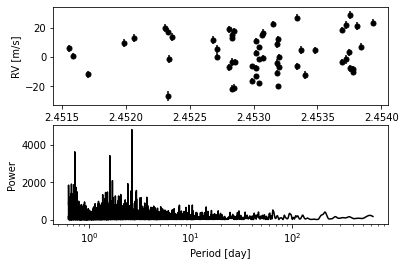

In [9]:
plt.subplot(2, 1, 1)
plt.errorbar(x, y , e, ms=5, marker="o", ls="none", color="black")
plt.xlabel("Time [JD]")
plt.ylabel("RV [m/s]")

plt.subplot(2, 1, 2)
plt.plot(2 * np.pi / f, pgram, color="black")
plt.xscale("log")
plt.xlabel("Period [day]")
plt.ylabel("Power")


In [10]:
print("The period with the highest power is: ", 2 * np.pi / f[np.where(pgram == np.max(pgram))][0], " day")

The period with the highest power is:  2.6439321027765184  day


## Now gather information for orbital solution from references, we are ready for MCMC, which gives uncertainties for best-fit parameters.



## Define a model function with five parameters: 

## period (day), time at periastron (MJD), eccentricity, argument of periastron (degree), RV amplitude (m/s)

In [16]:
per = 2.64388312
t0 = 2455959
ecc = 0.13827
omega = 351.00
rv_amp = 17.09

def calcModel(params, t_stamp=None):
     per, t0, ecc, omega, rv_amp = params["per"], params["t0"], params["ecc"], params["omega"], params["K"]
     rv = JW_lib.RadialVelocity([per, t0, ecc, omega, rv_amp])
     return(rv.rv_drive(t_stamp))

def calcModel(params, t_stamp=None):
    per, t0, ecc, omega, rv_amp = params["per"], params["t0"], params["ecc"], params["omega"], params["K"]
    return(radvel.kepler.rv_drive(t_stamp, [per, t0, ecc, omega, rv_amp], use_c_kepler_solver=False))

## Define prior function 

In [15]:
# DONT CHANGE THIS ONE IT IS FOR REFERENCE WILL DELETE AT THE END
def b_range(x, b):
    if x > b:
        return -np.inf
    else:
        return 0.

def a_b_range(x, a, b):
    if x < a:
        return -np.inf
    elif x > b:
        return -np.inf
    else:
        return 0.

def log_gaussian_prior(x, x0, std):
    return((-(x - x0)**2 / (2 * (std)**2)) / 2.3)




# define data and params that are fixed and variable
#planet_name = "HD 17156 b"
planet_name = "HD 17156 b"

if planet_name == "Teegarden b":
    log_priors = {}
    log_priors['per']           = lambda x: a_b_range(x, 4.8, 5.0)
    log_priors['t0']           = lambda x: a_b_range(x, 2458090.603207, 2458092.603207)
    log_priors['ecc']           = lambda x: a_b_range(x, 0., 0.95)
    log_priors['omega']       = lambda x: a_b_range(x, 0., 2*np.pi)
    log_priors['K']           = lambda x: a_b_range(x, 1., 5.)
    t_stamp      = rv_tg["col1"]
    data         = rv_tg["col2"]
    data_errors  = rv_tg["col3"]

    params = [4.910122, 2458091.603207, 0.222619, 82.339257 / 360 * 2 * np.pi,2.156248]
    params_keys = ["per", "t0", "ecc", "omega", "K"]
    params_fixed = []
    params_fixed_keys = []
elif planet_name == "HD 17156 b":
    log_priors = {}
    log_priors['per']           = lambda x: a_b_range(x, 20, 22)
    log_priors['t0']           = lambda x: a_b_range(x, 2454436.751157, 2454440.751157)
    log_priors['ecc']           = lambda x: a_b_range(x, 0., 0.95)
    log_priors['omega']       = lambda x: a_b_range(x, 0., 360.)
    log_priors['K']           = lambda x: a_b_range(x, 100., 500.)
    t_stamp      = rv_data["JD"]
    data         = rv_data["Radial_Velocity"]
    data_errors  = rv_data["Radial_Velocity_Uncertainty"]

    params = [21.218473, 2454438.751157, 0.680984, 121.36 / 360 * 2 * np.pi, 275.6]
    params_keys = ["per", "t0", "ecc", "omega", "K"]
    params_fixed = []
    params_fixed_keys = []
else:
    print(""" Give me either "HD 17156 b" or "Teegarden b" """)


In [ ]:
def b_range(x, b):
    if x > b:
        return -np.inf
    else:
        return 0.

def a_b_range(x, a, b):
    if x < a:
        return -np.inf
    elif x > b:
        return -np.inf
    else:
        return 0.

def log_gaussian_prior(x, x0, std):
    return((-(x - x0)**2 / (2 * (std)**2)) / 2.3)




# define data and params that are fixed and variable

planet_name = "GJ 436"

if planet_name == "Teegarden b":
    log_priors = {}
    log_priors['per']           = lambda x: a_b_range(x, 2.5, 2.7)
    log_priors['t0']           = lambda x: a_b_range(x, 2455958, 2455960)
    log_priors['ecc']           = lambda x: a_b_range(x, 0., 0.95)
    log_priors['omega']       = lambda x: a_b_range(x, 0., 2*np.pi)
    log_priors['K']           = lambda x: a_b_range(x, 10, 20)
    t_stamp      = rv_tg["col1"]
    data         = rv_tg["col2"]
    data_errors  = rv_tg["col3"]

    params = [2.64388312, 2455959,  0.13827, 351.00 / 360.0 * 2 * np.pi, 17.09]
    params_keys = ["per", "t0", "ecc", "omega", "K"]
    params_fixed = []
    params_fixed_keys = []
elif planet_name == "HD 17156 b":
    log_priors = {}
    log_priors['per']           = lambda x: a_b_range(x, 20, 22)
    log_priors['t0']           = lambda x: a_b_range(x, 2454436.751157, 2454440.751157)
    log_priors['ecc']           = lambda x: a_b_range(x, 0., 0.95)
    log_priors['omega']       = lambda x: a_b_range(x, 0., 360.)
    log_priors['K']           = lambda x: a_b_range(x, 100., 500.)
    t_stamp      = rv_data["JD"]
    data         = rv_data["Radial_Velocity"]
    data_errors  = rv_data["Radial_Velocity_Uncertainty"]

    params = [21.218473, 2454438.751157, 0.680984, 121.36 / 360 * 2 * np.pi, 275.6]
    params_keys = ["per", "t0", "ecc", "omega", "K"]
    params_fixed = []
    params_fixed_keys = []
else:
    print(""" Give me either "HD 17156 b" or "Teegarden b" """)

## Define likelihood function 

In [ ]:
def calc_log_prob(params, data, data_errors, params_keys=params_keys, params_fixed=params_fixed, \
                  params_fixed_keys=params_fixed_keys, t_stamp=t_stamp, plot_flag=False):
    # Make dictionary 
    params_dic = {}
    for i, key in enumerate(params_keys):
        params_dic[key]       = params[i]

    for i, key in enumerate(params_fixed_keys):
        params_dic[key]       = params_fixed[i]

    # Prior calculation of all input parameters
    log_prior = 0.

    for key in params_keys:
        if not(type(params_dic[key]) is list):
            log_prior += log_priors[key](params_dic[key])
        else:
            for val in params_dic[key]:
                log_prior += log_priors[key](val)

    # Return -inf if parameters fall outside prior distribution
    if (log_prior == -np.inf):
        return -np.inf
    
    # Calculate the log-likelihood
    log_likelihood = 0.

    # Calculate the forward model, this
    # returns the wavelengths in um and flux in W/m2

    rv_model = calcModel(params_dic, t_stamp=t_stamp)

    if plot_flag:
        plt.plot(t_stamp, rv_model, "k^-", alpha=0.5, label="model")
        plt.plot(t_stamp, data, "rx-", alpha=0.5, label="data")
        plt.xlabel("Time [BJD]")
        plt.ylabel("RV [m/s]")
        plt.legend()
        plt.show()

    # Just to make sure that a long chain does not die
    # unexpectedly:
    # Return -inf if forward model returns NaN values
    if np.sum(np.isnan(rv_model)) > 0:
        print("NaN spectrum encountered")
        return -np.inf

    # Calculate log-likelihood
    log_likelihood += -np.sum(((rv_model - data)/ \
                       data_errors)**2.)/2.

    if np.isnan(log_prior + log_likelihood):
        return -np.inf
    else:
        return log_prior + log_likelihood



## Test: calculate likelihood function

In [ ]:
print(calc_log_prob(params, data, data_errors, plot_flag=True))

## Now MCMC

In [ ]:
import emcee

In [ ]:
per = params[0]; e_per = 0.01
t0 = params[1]; e_t0 = 0.05
ecc = params[2]; e_ecc = 0.01
omega = params[3]; e_omega = 0.1
K = params[4]; e_K = 0.1


p_0 = params
e_p = [e_per, e_t0, e_ecc, e_omega, e_K]


ndim, nwalkers, nruns = len(p_0), 200, 1000
pos = [p_0 + e_p*np.random.randn(ndim) for i in range(nwalkers)]

import time as timer
start = timer.time()

from multiprocessing import Pool

# if pool works then use True, this option will use multi thread to increase computaional speed. Otherwise use False.
if False: 
    with Pool() as pool:

        # Initialize the sampler
        sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_log_prob,
                                       args=(data, data_errors), pool=pool, threads=5)
        sampler.run_mcmc(pos, 3000)


        #End timer
        end = timer.time()
        serial_time = end - start
        print("MCMC took {0:.1f} seconds".format(serial_time))
else:
        # Initialize the sampler
        sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_log_prob,
                                       args=(data, data_errors))
        sampler.run_mcmc(pos, 3000)


        #End timer
        end = timer.time()
        serial_time = end - start
        print("MCMC took {0:.1f} seconds".format(serial_time))    




## Check MCMC result

In [ ]:
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))[0:-1:10, :]


print("flat chain shape: {0}".format(samples.shape))


In [ ]:
import corner
fig = corner.corner(samples, labels=params_keys, plot_contours=True)


## Plot models with data

In [ ]:
fig, ax = plt.subplots(2,1)

inds = np.random.randint(len(samples[:,0]), size=100)
for ind in inds:
    # Make dictionary 
    params_dic = {}
    for i, key in enumerate(params_keys):
        params_dic[key]       = samples[ind,:][i]        
    for i, key in enumerate(params_fixed_keys):
        params_dic[key]       = params_fixed[i]
    #print(params_dic["logg"])
    rv_model = calcModel(params_dic, t_stamp=t_stamp)
    ax[0].plot(t_stamp, rv_model, 'r', alpha=0.05,label='_nolegend_')
    
    
ax[0].errorbar(t_stamp, data, data_errors, ms=5, marker="o", alpha=0.2, ls="none", color="black", label="Data")
ax[0].plot(t_stamp, rv_model, "r", alpha=0.5, label="Model")


# Getting median values
values = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
params = np.array(list(values))[:,0]
params_fixed = []
params_dic = {}
for i, key in enumerate(params_keys):
    params_dic[key]       = params[i]
for i, key in enumerate(params_fixed_keys):
    params_dic[key]       = params_fixed[i]


rv_model = calcModel(params_dic, t_stamp=t_stamp)
per = params_dic["per"]
ind1 = np.argsort(t_stamp % per)
ax[1].errorbar(t_stamp % per, data, data_errors, ms=5, marker="o", alpha=0.2, ls="none", color="black", label="Data")
ax[1].plot((t_stamp % per)[ind1], rv_model[ind1], "r", alpha=0.5,label='Model', lw=3)

ax[1].set_xlabel("Time [BJD]", fontsize=15)
ax[0].set_ylabel("RV [m/s]", fontsize=15)
ax[1].set_ylabel("RV [m/s]", fontsize=15)

plt.gca().tick_params(labelsize=15)
ax[1].legend(fontsize=15)
# plt.tight_layout()
# plt.savefig("model_data.png")

In [ ]:
print(limb_darkening_coefficients)